# HR Analytics: Job Change of Data Scientists
**Challenge: Predict who will move to a new job**

In [58]:
# For AWS related
import boto3
import sagemaker

import io
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 1 - Getting the data ready

### Data Loading from S3
Get the file names by connecting to an AWS client (here S3) using boto3. [Refer docs](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/core/session.html#boto3.session.Session.client)

In [2]:
client = boto3.client('s3')
name = 'hr-analytics-2021'

# Listing objects loaded from the bucket
obj_list = client.list_objects(Bucket=name)

filenames = [content['Key'] for content in obj_list['Contents']]
filenames

['aug_test.csv', 'aug_train.csv', 'sample_submission.csv']

In [3]:
def load_files(file):
    # Get the desired object
    obj = client.get_object(Bucket=name, Key=file)
    
    # This object contains file metadata like its type, modification time, etc.
    # The Body in this contains the streaming data to read
    data_bytes = obj['Body'].read()
    
    # Convert streaming data in bytes to a file in memory 
    data = io.BytesIO(data_bytes)
    df = pd.read_csv(data)
    return df

In [4]:
aug_test = load_files('aug_test.csv')
aug_train = load_files('aug_train.csv')
sample_submission = load_files('sample_submission.csv')

### Data Pre-Processing

In [5]:
aug_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [6]:
aug_train.describe(include='all')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19158.000000,19158,19158.000000,14650,19158,18772,18698,16345,19093,13220,13018,18735,19158.000000,19158.000000
unique,NaN,123,NaN,3,2,3,5,6,22,8,6,6,NaN,NaN
top,NaN,city_103,NaN,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,NaN,NaN
freq,NaN,4355,NaN,13221,13792,13817,11598,14492,3286,3083,9817,8040,NaN,NaN
mean,16875.358179,NaN,0.828848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.366896,0.249348
std,9616.292592,NaN,0.123362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.058462,0.432647
min,1.000000,NaN,0.448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,8554.250000,NaN,0.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,0.000000
50%,16982.500000,NaN,0.903000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.000000,0.000000
75%,25169.750000,NaN,0.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.000000,0.000000


In [7]:
fill_list = []
for col in aug_train.columns:
    if len(aug_train[aug_train[col].isna()]):
        fill_list.append(col)

fill_list        

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [8]:
# Fill NA with forward fill strategy
def fill(df, fill_list):
    for col in fill_list:
        df[col] = df[col].fillna(method='ffill')
        # In case 1st row is empty
        df[col] = df[col].fillna(method='bfill')
        
    return df

aug_train = fill(aug_train, fill_list)
aug_test = fill(aug_test, fill_list)

def check(df):   # Assert all column are filled
    for col in fill_list:
        if len(df[df[col].isna()]):
            print(f'{col} has nulls')
            
check(aug_train)            
check(aug_test)            

#### Modifying columns separately

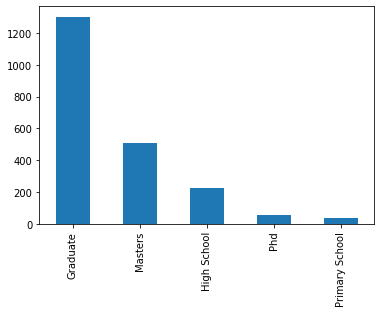

In [9]:
# 1. Education level 
aug_test.education_level.value_counts().plot.bar();

In [10]:
# Replacing school level education
aug_train = aug_train.replace(['Primary School', 'High School'], 'School')
aug_test = aug_test.replace(['Primary School', 'High School'], 'School')

#### Handling the numerical columns

In [11]:
# Replacing the default 
aug_train = aug_train.replace('never', '0')
aug_test = aug_test.replace('never', '0')

In [23]:
def replace_int(df, num_col):
    for col in num_col:
        for i in range(len(df)):
            val = df.loc[i,col]
            val = int(re.search('\d+',str(val)).group(0))                    
            df.loc[i,col] = val
       
    type_dict = {c:'int32' for c in num_col}
    df = df.astype(type_dict)
    return df

num_col = ['experience', 'company_size', 'last_new_job']

aug_train = replace_int(aug_train, num_col)
aug_test = replace_int(aug_test, num_col)

### Upload processed data to S3

First we save in required format locally and then save it to S3 in the correct format (as needed for the chosen model)

In [26]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# The SageMaker session we are currently operating in
session = sagemaker.Session()

# The IAM role that we are currently assigned. 
role = get_execution_role()

#### Formatting the data 

In [31]:
# Multiple cities that would only overfit our data. 
len(aug_train.city.unique()), len(aug_test.city.unique())

(123, 108)

In [34]:
from sklearn.model_selection import train_test_split

# Making train and validation data for our hyperparameters
Y = aug_train['target']
X = aug_train.iloc[:,2:-1] # Get required columns only

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

# Test data
X_test = aug_test.iloc[:,2:]

**Saving data locally**

In [35]:
data_dir = './processed'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Saving data w/o headers as required by Sagemaker models
# Test data
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# Train and validation data - Sagemaker XGBoost requires Y to be the 1st column
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)

**Uploading processed data to S3**

In [46]:
train_location = session.upload_data(path = os.path.join(data_dir, 'train.csv'), bucket = name)
validation_location = session.upload_data(path = os.path.join(data_dir, 'validation.csv'), bucket = name)
test_location = session.upload_data(path = os.path.join(data_dir, 'test.csv'), bucket = name)

## Part 2 - Training the model

For this classification, we can load our model to train on desired instance.

Select the right [training instances](https://aws.amazon.com/sagemaker/pricing/) is important. Example: Due to hyperparameter optimization, more CPU instances are preferred

In [50]:
container = get_image_uri(session.boto_region_name, 'xgboost', '1.0-1')

prefix = 'data'
# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    instance_count=1, 
                                    instance_type='ml.m5.2xlarge', 
                                    output_path='s3://{}/{}/output'.format(name, prefix),
                                    sagemaker_session=session)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


For the model, we first set fixed hyperparameters. The rest can be optimized based on training instance. 

[Refer docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for XGBoost's hyperparameters

In [51]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:logistic',
                        early_stopping_rounds=10,
                        num_round=200)

In [52]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, 
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 7, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [53]:
input_train = sagemaker.TrainingInput(s3_data=train_location, content_type='csv')
input_validation = sagemaker.TrainingInput(s3_data=validation_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': input_train, 'validation': input_validation})

............................................................................................................................................!


In [55]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-210301-0510-014-5df51f21'

## Loading the best model

In [ ]:
trainedmodel = sagemaker.model.Model(
    image_uri = container,
    model_data='s3://{}/{}/output/{}/output/model.tar.gz'.format(name, prefix, xgb_hyperparameter_tuner.best_training_job()),
    role=role)  

trainedmodel.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

## Batch Predictions

In [56]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2021-03-01 05:17:39 Starting - Preparing the instances for training
2021-03-01 05:17:39 Downloading - Downloading input data
2021-03-01 05:17:39 Training - Training image download completed. Training in progress.
2021-03-01 05:17:39 Uploading - Uploading generated training model
2021-03-01 05:17:39 Completed - Training job completed


In [57]:
xgb_transformer = xgb_attached.transformer(
    instance_count = 1, 
    instance_type = 'ml.m4.xlarge',
    output_path = 
)

In [61]:
test_location

's3://hr-analytics-2021/data/test.csv'

In [60]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

................................[2021-03-01:13:22:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-01:13:22:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-01:13:22:11:INFO] nginx config: 
worker_processes auto;
daemon off;
[2021-03-01:13:22:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-01:13:22:11:INFO] No GPUs detected (normal if no gpus installed)
[2021-03-01:13:22:11:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      pr

UnexpectedStatusException: Error for Transform job sagemaker-xgboost-2021-03-01-13-17-04-979: Failed. Reason: ClientError: See job logs for more information